<a href="https://colab.research.google.com/github/JLaura011/Business-Analytics/blob/master/Sesi%C3%B3n_3_Segmentaci%C3%B3n_An%C3%A1lisis_cl%C3%BAster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sesión 3: Análisis Cluster**
<img src="https://www.grupolambda.com.pe/wp-content/uploads/2020/03/home-logo.png" alt="drawing" width="300"/>
<br>

 ##### Docente: Jorge Brian Alarcon Flores 

#**SEGMENTACIÓN ANÁLISIS CLUSTER**

Para realizar el análisis de segmentación con algoritmos de machine learning se ha considerado un conjunto de datos de tárjeta de crédito de un banco, donde se cuenta con algunas características del cliente como edad, género, trabajo, duración, propósito del crédito, entre otros.

In [ ]:
#Importamos las librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Importamos la base de datos
url = 'https://raw.githubusercontent.com/JBrianAlicorp/Business-Analytics/master/Data_banca_segmentacion.csv'
data = pd.read_csv(url,encoding='latin1')

**Variables**

1. Edad (numérico)
2. Sexo (texto: masculino, femenino)
3. Trabajo (numérico: 0 - no calificado y no residente, 1 - no calificado y residente, 2 - calificado, 3 - altamente calificado)
4. Vivienda (texto: propio, alquiler o gratis)
5. Cuentas de ahorro (texto: poco, moderado, bastante rico, rico)
6. Cuenta corriente (numérica, en DM - Marca alemana)
7. Monto de crédito (numérico, en DM)
8. Duración (numérica, en mes)
9. Propósito (texto: automóvil, muebles / equipo, radio / TV, electrodomésticos, reparaciones, educación, negocios, vacaciones / otros)

In [ ]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


Parece que la primera columna es simplemente un índice que podemos eliminar. Comprobamos cuántos valores faltantes hay en cada columna y de qué tipos de datos son.

In [ ]:
data.drop(data.columns[0], inplace=True, axis=1)
print("Base de datos tiene {} observaciones (clientes) y {} columnas (variables).".format(data.shape[0],data.shape[1]))
print("Valores perdidos por cada variable:\n{}".format(data.isnull().sum()))
print("Tipo de variables:\n{}".format(data.dtypes))

Base de datos tiene 1000 observaciones (clientes) y 9 columnas (variables).
Valores perdidos por cada variable:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
Tipo de variables:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


De las 9 columnas 2 contienen valores faltantes. Probablemente se trata de clientes que no tienen una de estas dos cuentas.

En general, hay 4 variables numéricas y 5 categóricas.

Ahora comprobamos cuántos y cuáles son los valores posibles (únicos) en cada columna categórica.

In [ ]:
n_unique = data.nunique()
print("Número de valores únicos:\n{}".format(n_unique))

Número de valores únicos:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [ ]:
print("Valores únicos en cada columna categórica:")
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Valores únicos en cada columna categórica:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


**Análisis exploratorio**

Definimos una función que generará gráficos para tres variables numéricas con estratificación por columna categórica seleccionada.

In [ ]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

At the beginning let’s look at scatter plots our 3 numerical variables stratified by sex.



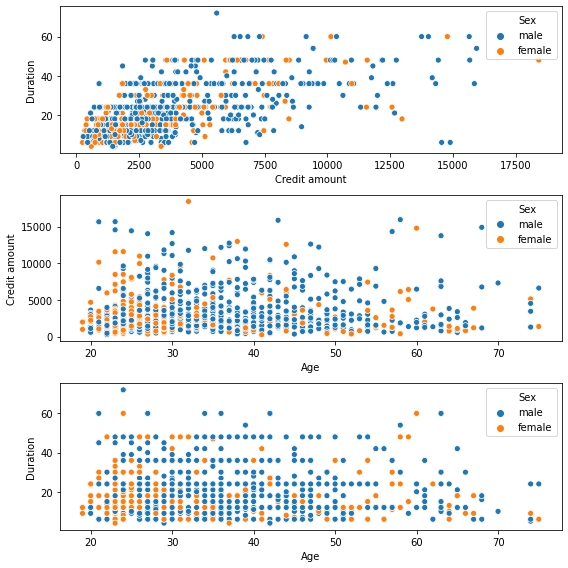

In [ ]:
scatters(data, h="Sex")

* La impresión general es que las mujeres tienden a ser más jóvenes que los hombres, sin embargo, la primera gráfica muestra que no hay una diferencia clara entre hombres y mujeres en términos de monto y duración del crédito. 

* De la inspección visual, parece que hay una correlación positiva entre la duración y la cantidad de crédito, lo que tiene sentido.

* Verifiquemos la correlación lineal entre el monto del crédito y la duración.




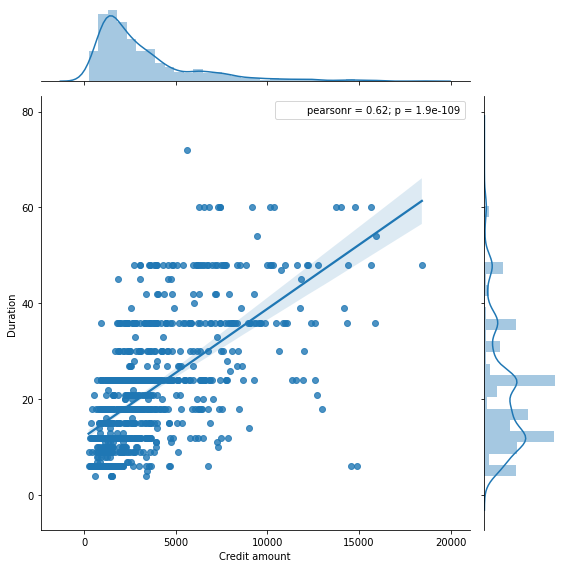

In [ ]:
import scipy.stats as stats
r1 = sns.jointplot(x="Credit amount",y="Duration", data=data, kind="reg", height=8)
r1.annotate(stats.pearsonr)
plt.show()

El gráfico anterior muestra una correlación lineal con el valor de Pearson de 0.62 y un valor p muy pequeño. 

Eso tiene sentido porque, por lo general, las personas toman créditos más grandes por períodos más largos. A continuación analizaré gráficos de regresión lineal con varias categorizaciones.

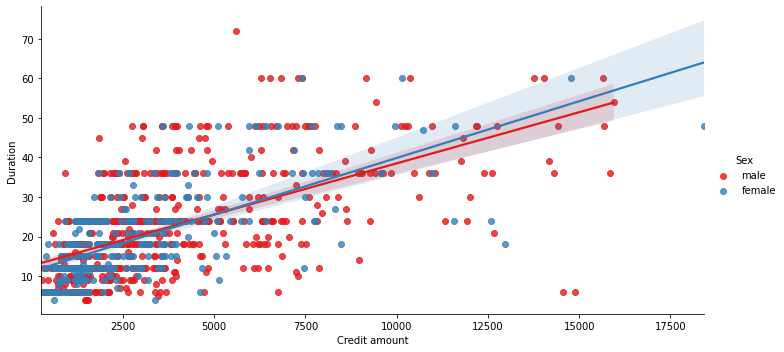

In [ ]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set1", aspect=2)
plt.show()

La gráfica anterior indica que no hay una diferencia significativa entre hombres y mujeres.

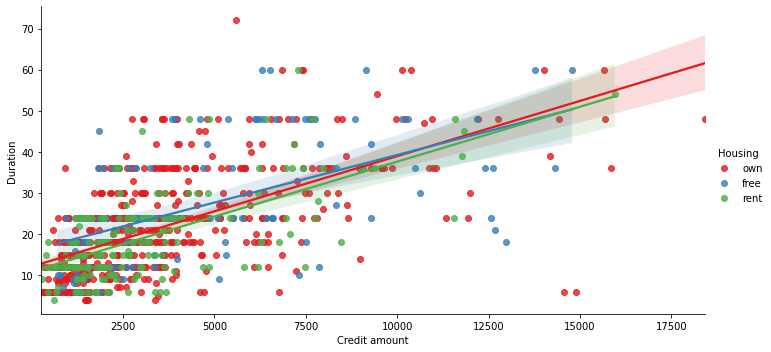

In [ ]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data, palette="Set1", aspect=2)
plt.show()

La gráfica anterior muestra de manera similar que no hay diferencia entre las categorías de viviendas.

A continuación, mostraré el área de "negocios" donde se otorga la mayor cantidad de créditos.

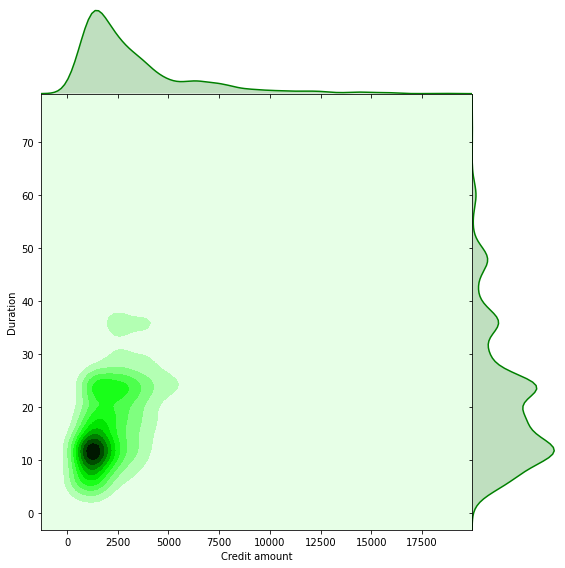

In [ ]:
sns.jointplot("Credit amount","Duration", data=data, kind="kde", space=0, color="g",  height=8)
plt.show()

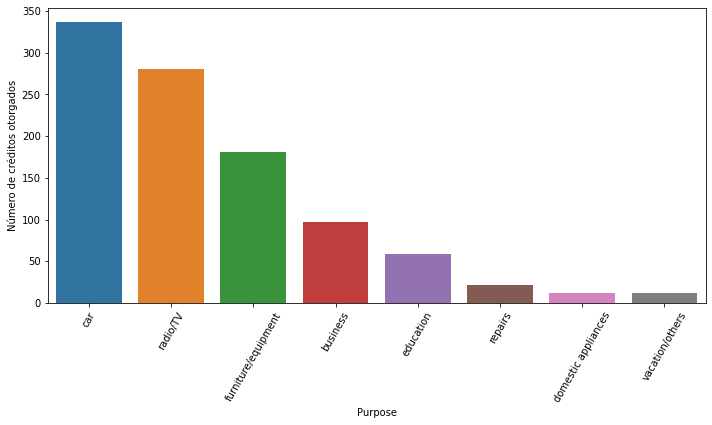

In [ ]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Número de créditos otorgados")
plt.tight_layout()

El diagrama de barras anterior muestra cuántos créditos se otorgaron para diversos fines. La mayoría de los créditos se otorgaron para automóviles y radio / TV.

Ahora generaremos diagramas de caja para el análisis detallado de variables categóricas.

In [ ]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

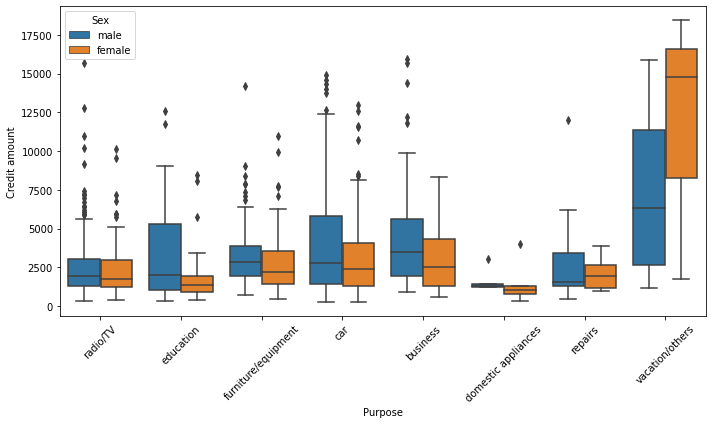

In [ ]:
boxes("Purpose","Credit amount","Sex")

La gráfica anterior muestra que las cantidades más grandes se toman para vacaciones / otros, las más pequeñas para electrodomésticos. 

La mayoría de ellos tienen valores atípicos en la parte superior de las cajas (cantidades más altas). 

En la mayoría de los casos no hay diferencia entre hombres y mujeres, a pesar de la categoría vacaciones / otros. Pero uno debe recordar que había muy pocos créditos otorgados en esta categoría.

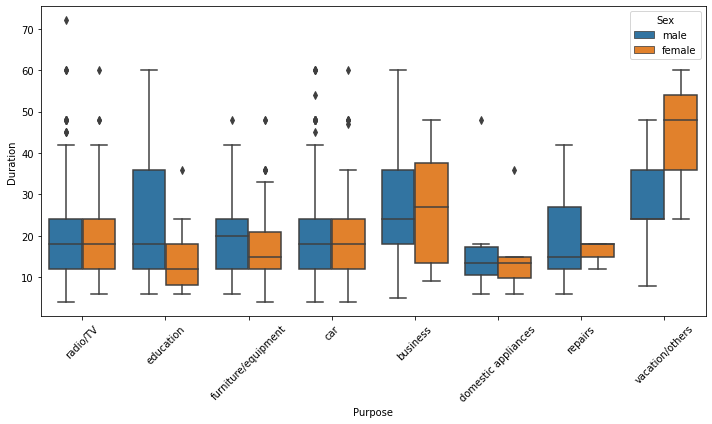

In [ ]:
boxes("Purpose","Duration","Sex")

El diagrama de caja anterior indica que generalmente no hay diferencia en la duración del crédito entre hombres y mujeres. No podemos ver también una tendencia clara entre las categorías con observaciones de que la duración más corta es para electrodomésticos. 

Tiene sentido ya que está de acuerdo con las ideas del gráfico anterior (monto del crédito): en esta categoría, hay los montos más bajos de créditos.

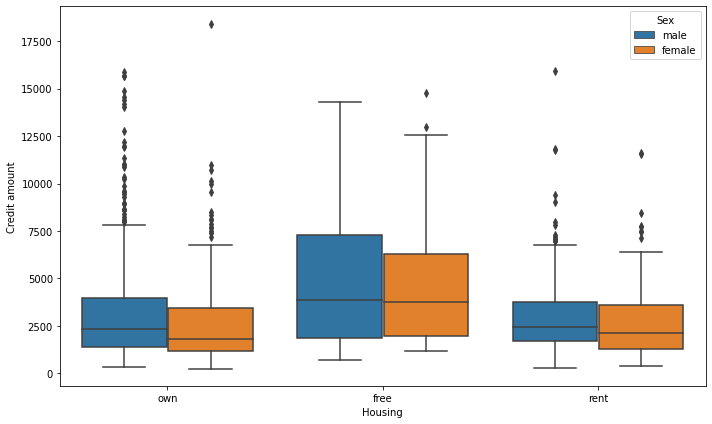

In [ ]:
boxes("Housing","Credit amount","Sex",r=0)

En términos de categoría de vivienda, no existe una gran diferencia a pesar de que las personas que tienen viviendas "gratuitas" tienden a tomar montos de crédito ligeramente mayores.

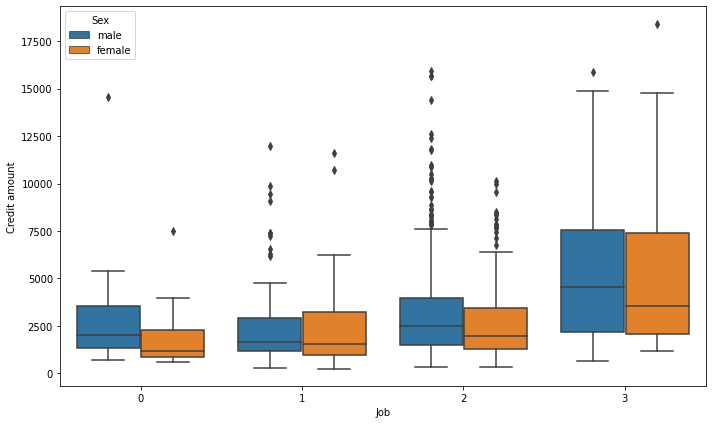

In [ ]:
boxes("Job","Credit amount","Sex",r=0)

En términos de categoría de trabajo, una vez más no hay diferencia entre hombres y mujeres, pero podemos ver que la categoría de trabajo 3 ("Altamente calificado") tiende a tomar montos de crédito más grandes para una mayor duración.

Y al final, si a alguien le gustan las tramas 3D, aquí tienes.

Text(0.5, 0, 'Age')

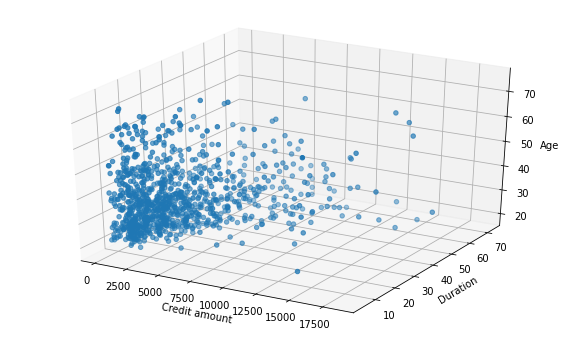

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

**Clustering con KMeans**

Para la agrupación, crearemos un subconjunto que contenga solo variables numéricas (Edad, Cantidad de crédito, Duración).

In [ ]:
#Seleccionamos columnas para clusterización con K-means
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

Creamos una función que genere tres histogramas, uno para cada variable.



In [ ]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

Vemos los histogramas



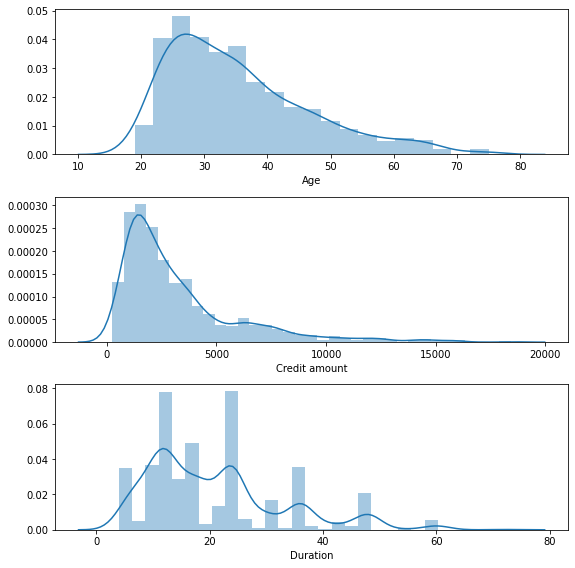

In [ ]:
distributions(cluster_data)

Podemos ver que las distribuciones están sesgadas a la derecha, pero para trabajar con clustering necesito que **todas mis variables sean comparables** qué hago:

**1. Transformación de variables**

Para obtener mejores resultados, debemos eliminar la asimetría por transformación logarítmica. 

Cuando se tienen distribuciones de frecuencias con asimetría negativa (frecuencias altas hacia el lado derecho de la distribución), es conveniente aplicar la transformación logarítmica. Esta transformación comprime la escala para valores pequeños y la expande para valores altos. Muchas distribuciones de datos económicos, o de consumos se convierten en simétricas utilizando esta transformación.

Después de eso, veamos cómo se ven.

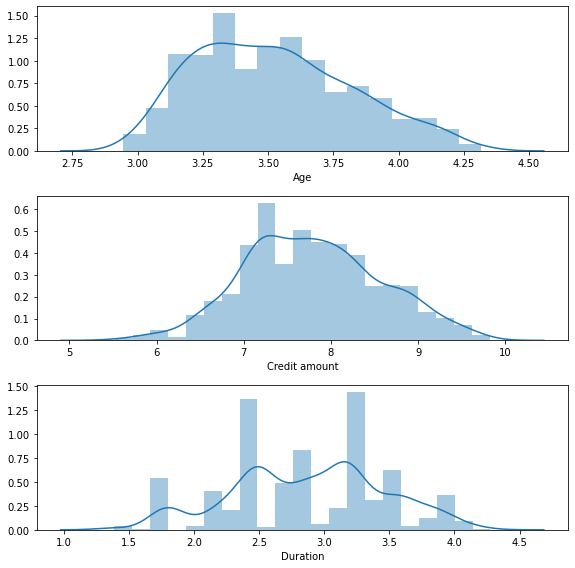

In [ ]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

De hecho, la asimetría ha sido eliminada.

**2. Estandarización de variables**

El siguiente paso será centrar y escalar las variables: es requerido por el algoritmo KMeans. Utilizaremos para eso un **StandardScaler** de la biblioteca sklearn, la cual estandariza los datos eliminando la media y escalando los datos de forma que su varianza sea igual a 1.

In [ ]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

**Gráfico de sedimentación**

Nos da una intuición visual de la cantidad de clusters que puedo seleccionar de mi conjunto de datos

Comprobaremos cómo cambia la inercia para varios grupos.

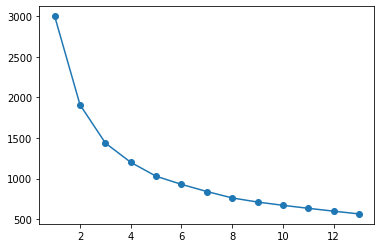

In [ ]:
clusters_range = [1,2,3,4,5,6,7,8,9,10,11,12,13]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

El gráfico anterior muestra que la inercia disminuye con el aumento del número de grupos.

Este método además permite la evaluación de las separaciones de grupos y el ajuste de cada observación en su propio grupo. 

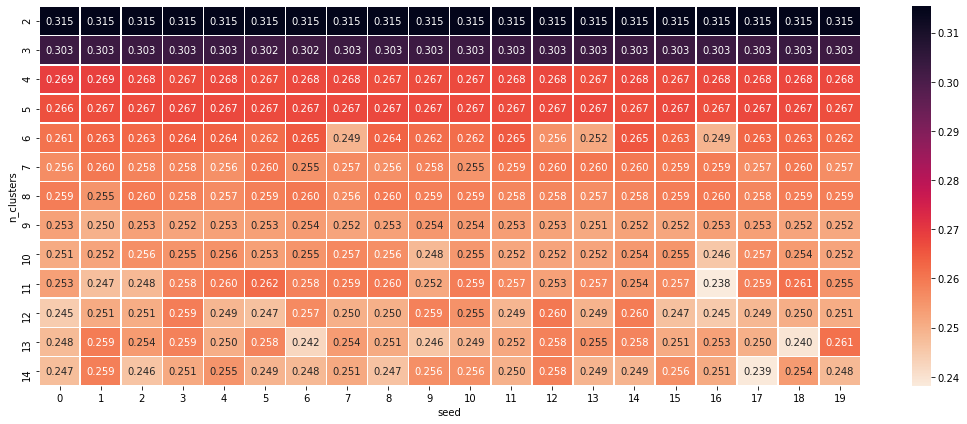

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

El mapa de calor anterior muestra las puntuaciones de silueta para varias combinaciones de estado aleatorio y número de grupos. Los puntajes más altos son para 2 y 3 grupos y son relativamente insensibles a la semilla.

Elegiré 3 grupos para obtener más información sobre los datos.

In [ ]:
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

A continuación, crearé un gráfico de silueta para 3 grupos para representar visualmente el ajuste de cada punto dentro de su propio grupo.

For n_clusters = 3  and seed = 19 
The average silhouette_score is : 0.30318933408774545


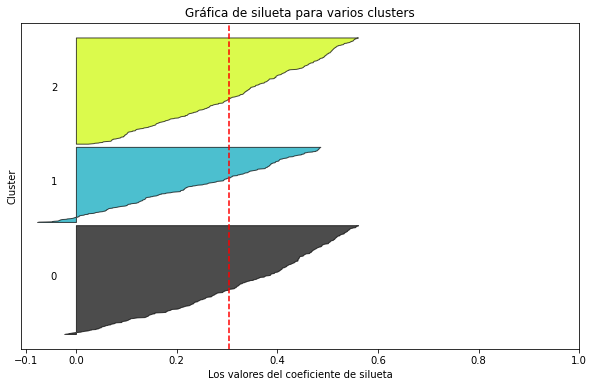

In [ ]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=3, random_state=1)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 3," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("Gráfica de silueta para varios clusters")
ax1.set_xlabel("Los valores del coeficiente de silueta")
ax1.set_ylabel("Cluster")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

**Interpretación de los clusters**

Definimos una función que muestre los clusters en el diagrama de dispersión.

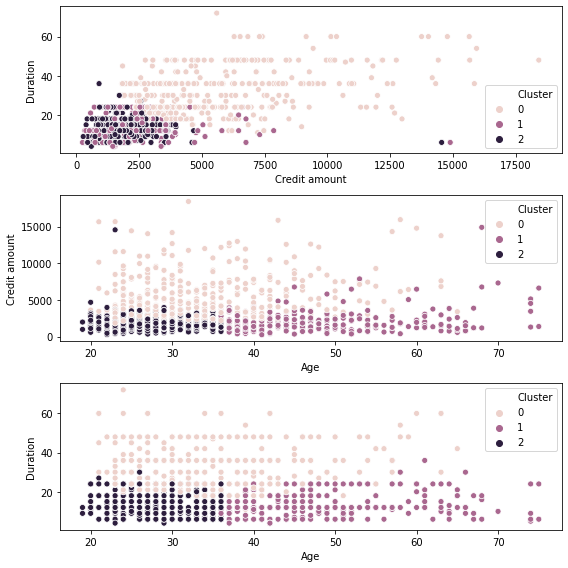

In [ ]:
scatters(clustered_data, 'Cluster')

Las gráficas anteriores muestran tres grupos creados. Las dos últimas muestran una separación relativamente clara de los grupos, pero no es tan evidente en el primero.


Calculamos los valores promedios obtenidos en cada variable por cluster.

In [ ]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,34.0,5665.4,32.2
1,48.7,1979.7,13.9
2,27.8,1732.2,14.2


1. **Cluster 0** - menor media del monto del crédito, corta duración, clientes mayores

2. **Cluster 1** - alta media del monto del crédito, larga duración, clientes de mediana edad

3. **Cluster 2** - menor media del monto del crédito, corta duración, clientes jóvenes

**Clustering con Affinity Propagation**

En este algoritmo hay dos parámetros relevantes: preference y dumping. Significa que no definimos el número inicial de clústeres, el algoritmo mismo elige su número. Arreglaré el volcado y comprobaré el número de clústeres en función del parámetro de preferencia.

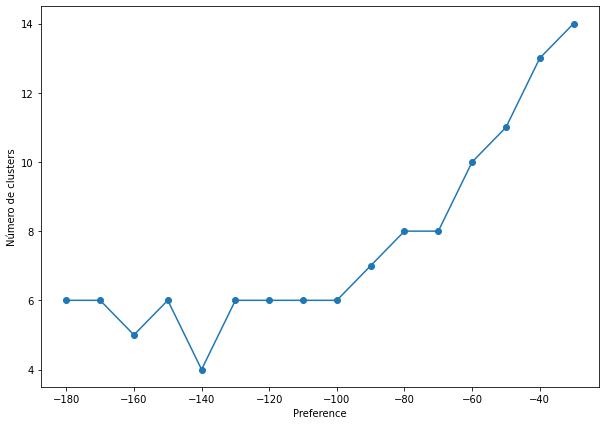

In [ ]:
preferences = np.arange(-30,-190,-10)
clusters = []

for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

plt.figure(figsize=(10,7))
plt.xlabel("Preference")
plt.ylabel("Número de clusters")
plt.plot(preferences,clusters, marker='o')

Junto con el valor decreciente del parámetro de preferencia, el número de grupos también disminuye y los niveles de valores de preferencia muy pequeños. Comprobaremos la opción de cuatro grupos.

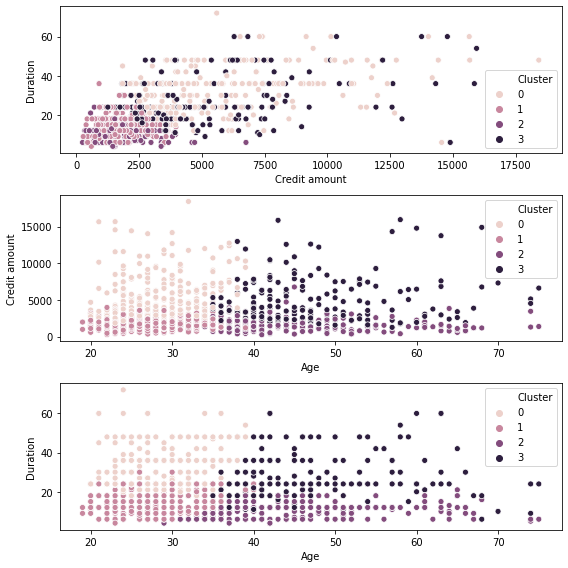

In [ ]:
af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af = pd.DataFrame(af.labels_)
n_clusters_ = len(af.cluster_centers_indices_)

clustered_data_af = cluster_data.assign(Cluster=labels_af)
scatters(clustered_data_af,'Cluster')

grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)

In [ ]:
grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)
grouped_af

,Age,Credit amount,Duration
Cluster,,,
0,28.7,5593.7,32.2
1,27.9,1654.3,15.1
2,46.0,1551.7,10.7
3,47.5,4977.9,27.6


1. **Cluster 0**: alta media del monto del crédito, larga duración, clientes más jóvenes

2. **Cluster 1** - bajo promedio del monto del crédito, corta duración, clientes más jóvenes

3. **Cluster 2** - bajo promedio del monto del crédito, corta duración, clientes mayores

4. **Cluster 3**: alta media del monto del crédito, duración de medio tiempo, cliente mayors

**¿Y también puedo usar variables categóricas en mi análisis cluster?**

Pues si, pero en primer lugar tendrías que transformar tus variables categóricas a numéricas, una de las formas más usadas de realizar esta transformación es el **one hot encoding**.

La estrategia que implementa es crear una columna para cada valor distinto que exista en la característica que estamos codificando y, para cada registro, marcar con un 1 la columna a la que pertenezca dicho registro y dejar las demás con 0. 

Por ejemplo, para el caso de la variable **sex** de nuestra data, One Hot Encoding crearía dos columnas (una para el valor "male" y otra para el valor "female") y, para cada cliente, asignaría un 1 a la columna de "male" y un 0 a la de "female" en el caso de ser un hombre, y viceversa en el caso de ser mujer (un 0 en la columna de "male" y un 1 en la de "female").

In [ ]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [ ]:
one_hot = pd.get_dummies(data['Sex'])
data = data.join(one_hot)
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,female,male
0,67,male,2,own,NaN,little,1169,6,radio/TV,0,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,1,0
2,49,male,1,own,little,NaN,2096,12,education,0,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,0,1
4,53,male,2,free,little,little,4870,24,car,0,1
